In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data

%matplotlib inline


In [50]:
# Import data
data = pd.read_excel("support_files/OSEBX.xlsx")

In [51]:
data.head()

,OSEBX,Last,High,Low,Official turnover (NOK)
0,2018-11-14,NaN,NaN,NaN,3.790000e+02
1,2018-11-13,875.43,887.95,875.17,5.126725e+09
2,2018-11-12,886.62,892.64,885.44,3.591581e+09
3,2018-11-09,886.44,892.58,884.16,4.405451e+09
4,2018-11-08,892.49,900.74,891.50,4.463838e+09


In [52]:
data.rename(columns={'OSEBX' : 'Date', 'Official turnover (NOK)' : 'Volume'}, inplace=True)

In [53]:
data['Date'] = pd.to_datetime(data['Date'])

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 5 columns):
Date      5743 non-null datetime64[ns]
Last      5742 non-null float64
High      4390 non-null float64
Low       4390 non-null float64
Volume    5624 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 224.4 KB


In [55]:
data['Direction'] = data.Last.diff().shift()

In [56]:
data['Direction'] = data.Direction.apply(lambda x: 1 if x > 0 else 0)

In [57]:
data['Close'] = data.Last.shift()
data.drop('Last', axis=1, inplace=True)

In [58]:
data.set_value(1, 'Close', 876.30)
data.set_value(0, 'Close', 872.10);

C:\anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [59]:
# Reorder columns
data = data[['Date', 'High', 'Low', 'Close', 'Volume', 'Direction']].copy()

In [60]:
# Sort the timeseries correctly with last observation on the last row (important for technical features)
data = data.sort_values(by='Date', ascending=True);

In [61]:
# Moving average indicators, short, medium and long term
data['SMA10'] = data.Close.rolling(10).mean()
data['SMA30'] = data.Close.rolling(30).mean()
data['SMA90'] = data.Close.rolling(90).mean()

In [62]:
# Exponential moving average 
data['EWA10'] = data['Close'].ewm(span=10, min_periods=10).mean()
data['EWA30'] = data['Close'].ewm(span=30, min_periods=30).mean()
data['EWA90'] = data['Close'].ewm(span=90, min_periods=90).mean()

In [63]:
# Stochastic Osciallator
data['SOI'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])

In [64]:
# 10, 5 and 2 Day Momentum
data['Momentum_10'] = data['Close'].diff(10)
data['Momentum_5'] = data['Close'].diff(5)
data['Momentum_2'] = data['Close'].diff(2)

In [65]:
data['STD'] = data['Close'].rolling(20, min_periods=20).std()

In [66]:
data['Day'] = data.Date.dt.dayofweek

In [67]:
data['Day'].replace({0: 'Monday', 1 : 'Tuesday', 2: 'Wednesday', 3 : 'Thursday', 4 : 'Friday'}, inplace=True);

In [68]:
data.Day.value_counts()

Tuesday      1172
Wednesday    1171
Friday       1149
Monday       1126
Thursday     1125
Name: Day, dtype: int64

In [69]:
data = pd.get_dummies(data);

In [70]:
data.reset_index(drop=True, inplace=True);

In [71]:
def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    
    return df

In [72]:
data = relative_strength_index(data, 14)

In [73]:
data.isnull().sum()

Date                0
High             1353
Low              1353
Close               0
Volume            119
Direction           0
SMA10               9
SMA30              29
SMA90              89
EWA10               9
EWA30              29
EWA90              89
SOI              1353
Momentum_10        10
Momentum_5          5
Momentum_2          2
STD                19
Day_Friday          0
Day_Monday          0
Day_Thursday        0
Day_Tuesday         0
Day_Wednesday       0
RSI_14           1352
dtype: int64

In [74]:
data.tail()

,Date,High,Low,Close,Volume,Direction,SMA10,SMA30,SMA90,EWA10,...,Momentum_10,Momentum_5,Momentum_2,STD,Day_Friday,Day_Monday,Day_Thursday,Day_Tuesday,Day_Wednesday,RSI_14
5738,2018-11-08,900.74,891.50,886.44,4.463838e+09,0,886.731,897.993333,899.857444,888.206148,...,23.64,-2.58,-9.17,12.630985,0,0,1,0,0,0.637307
5739,2018-11-09,892.58,884.16,886.62,4.405451e+09,1,887.815,896.143667,899.834778,887.917757,...,10.84,-6.97,-5.87,12.487752,1,0,0,0,0,0.501824
5740,2018-11-12,892.64,885.44,875.43,3.591581e+09,0,888.473,893.839333,899.571444,885.647256,...,6.58,-15.48,-11.01,11.813649,0,1,0,0,0,0.502821
5741,2018-11-13,887.95,875.17,876.30,5.126725e+09,0,887.137,891.706000,899.407667,883.947755,...,-13.36,-19.31,-10.32,10.976545,0,0,0,1,0,0.360389
5742,2018-11-14,NaN,NaN,872.10,3.790000e+02,0,885.851,889.777667,899.264444,881.793618,...,-12.86,-20.39,-3.33,11.038384,0,0,0,0,1,0.360389


In [75]:
data.dropna(inplace=True)

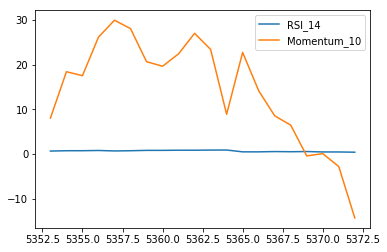

In [76]:
# Visualize sanity check
data.iloc[4000:4020].plot( y=['RSI_14', 'Momentum_10']);

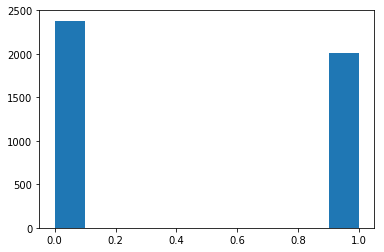

In [77]:
plt.hist(data.Direction);
plt.xlim();
        

In [78]:
# data.reset_index(drop=True, inplace=True)

In [79]:
# Set index to Date
data.set_index('Date', inplace=True)

In [80]:
data.replace(-np.inf, np.nan, inplace=True)

In [81]:
data.fillna(method='ffill', inplace=True)

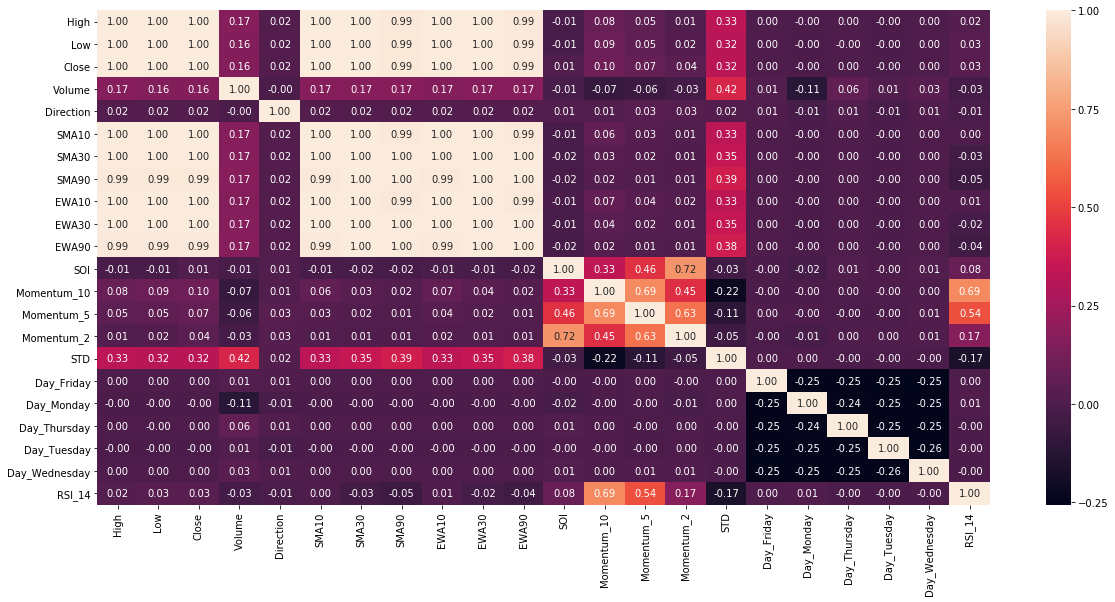

In [82]:
fig, ax = plt.subplots(figsize=(20,20))
plt.subplot(2,1,1)
sns.heatmap(data.corr(), annot=True, fmt='.2f');

In [83]:
# Split to target and features
target = data.Direction
features = data.drop(["Direction"], axis=1)

In [177]:
# Normalize the data
norm = MinMaxScaler(feature_range=(0,1))
features = norm.fit_transform(features)

In [178]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

In [179]:
features.shape

(4388, 21)

In [180]:
features_numpy = data.drop(["Direction"], axis=1).values
target_numpy = data.Direction.values

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(features_numpy, target_numpy, test_size=0.30, random_state=42)


In [40]:
clf = SVC(probability=True)

param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(clf, param_grid=param_dist_svm )
svmmodel.fit(X_train, y_train);


In [41]:
y_pred = svmmodel.predict_proba(X_test)


In [42]:
def roc_scores (y_predict, y_test=y_test):
    
    # Compute for probabilities for positive outcome
    fpr, tpr, tresholds = roc_curve(y_test, y_predict[:,1])
    roc_auc = roc_auc_score(y_test, y_predict[:,1])

    return fpr, tpr, tresholds, roc_auc

def plot_roc(fpr, tpr, roc_auc, title="ROC"):
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right");

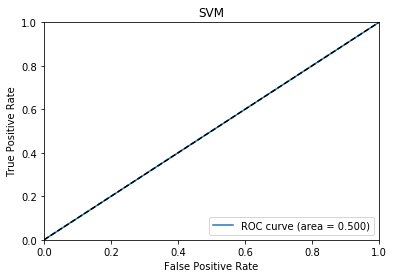

In [43]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_pred)
plot_roc(fpr,tpr,roc_auc, 'SVM')

In [44]:
lr = LogisticRegression()

In [45]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
y_perd_lr = lr.predict_proba(X_test)

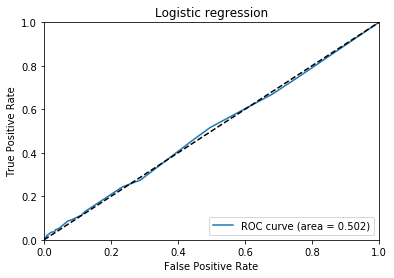

In [47]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_perd_lr)
plot_roc(fpr,tpr,roc_auc, 'Logistic regression')

In [48]:
rf = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist1 = {"max_depth": [5,10,15,20],
              "n_estimators" : [100, 1000, 10000],
              "min_samples_split": [3,5,10,15,20],
              "bootstrap": [True, False],
              "min_samples_leaf" : [3,5,10,15,20]
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(rf, param_distributions=param_dist1,
                                   n_iter=n_iter_search, cv=5, verbose=10, n_jobs=-1)
randommodel.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s


KeyboardInterrupt: 

In [ ]:
rf_pred = randommodel.predict_proba(X_test)

In [ ]:
fpr, tpr, tresholds, roc_auc = roc_scores(rf_pred)
plot_roc(fpr,tpr,roc_auc, 'Random Forest')

## Recurrent neural network

In [88]:
# Data from numpy
featuresTrain = torch.from_numpy(X_train_np).float()
targetsTrain = torch.from_numpy(y_train_np).float()

featuresTest = torch.from_numpy(X_test_np).float()
targetsTest = torch.from_numpy(y_test_np).float()

In [89]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# Data loader
trainloader = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = False)
testloader = torch.utils.data.DataLoader(test, batch_size = 32, shuffle = False)

In [229]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        self.inp = nn.Linear(21, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 2, dropout=0.05)
        
        self.out = nn.Linear(hidden_size, 1)
        self.softmax = nn.LogSoftmax(dim=1)
        

    def step(self, input, hidden=None):
        input = self.inp(input.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        
        output = self.out(output.squeeze(1))
        output = self.softmax(output)
        return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = torch.tanh(inputs[i])
            else:
                input = torch.tanh(output)
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden
    


In [230]:
def check_perfomance(loader, model, criterion, device, optimizer):
    """
    Validation function, takes dataloader, model, criterion, device and optimizer as 
    arguments and returns test_loss and accuracy
    """
    test_loss = 0
    accuracy = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    total = 0
    correct = 0
    model.eval()
    # Loop over images and labels in dataloader
    for features, labels in loader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
       
        # Calculate loss
        output = model.forward(features)
        test_loss += criterion(torch.squeeze(output[0]), labels).item()
        
#         # Accuracy
#         ps = torch.exp(output[0])
#         ps = ps.float()
#         equality = (labels.data == ps.max(dim=1)[1])
#         accuracy += equality.type(torch.FloatTensor).mean()

#         # Get predictions from the maximum value
#         predicted = torch.max(output[0].data, 1)[1]
#         predicted = predicted.float()
        
#         # Total number of labels
#         total += labels.size(0)

#         correct += (predicted == labels).sum()
        
#         accuracy = 100 * correct / 4400
# #         print("acc", accuracy)
        
        
    return test_loss, accuracy

In [233]:
def train_model(optimizer, criterion, model, epochs=1):
#     device = torch.device("cuda:0" if torch.cuda.is_available else 'cpu')
    device = 'cpu'
    model.to(device)
    steps = 0
    print_every = 100
    running_loss = 0
    

    for epoch in range(epochs):
        model.train()

        for features, label in trainloader:
            
            features.to(device)
            label.to(device)
            
            optimizer.zero_grad()
            
            output = model.forward(features)
            
            loss = criterion(torch.squeeze(output[0]), label)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            
            if steps % print_every == 0:
             
                with torch.no_grad():
                                                          
                    test_loss, accuracy = check_perfomance(testloader, model, criterion, device, optimizer)
                                
                print("Epoch: {}/{}... ".format(epoch+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every),
                      "Device : {}..".format(device),
                      "Test_loss : {}..".format(test_loss/len(testloader)),
                      "Test_Accuracy : {}..".format(accuracy/len(testloader)))
                             
                running_loss = 0
                model.train()
            
    return model


In [ ]:
hidden_size = 100
model = SimpleRNN(hidden_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

final_model = train_model(optimizer, criterion, model)



In [ ]:
def accuracy_test(model):    
    correct = 0
    total = 0
#     model.to('cuda:0')
    model.eval()
    with torch.no_grad():
        for inp, labels in testloader:
#             inp, labels = images.to('cuda:0'), labels.to('cuda:0')
            outputs = model(inp)
            
            _, predicted = torch.max(outputs[0], 1)
            predicted = predicted.float()
            print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum()
#             print(labels, predicted)
            

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    
accuracy_test(final_model)

## Keras

In [398]:
class Model(torch.nn.Module):

    def __init__(self, input_size, rnn_hidden_size, output_size):

        super(Model, self).__init__()

        self.rnn = torch.nn.RNN(input_size, rnn_hidden_size,
                                num_layers=2, nonlinearity='relu',
                                batch_first=True, dropout=0.05)
        
        self.h_0 = self.initialize_hidden(rnn_hidden_size)

        self.linear = torch.nn.Linear(rnn_hidden_size, output_size)
        self.softmax = nn.Sigmoid()

    def forward(self, x):

        x = x.unsqueeze(0)
        self.rnn.flatten_parameters()
        out, self.h_0 = self.rnn(x, self.h_0)

        out = self.linear(out)
        out = self.softmax(out)

        # third_output = self.relu(self.linear3(second_output))
        # fourth_output = self.relu(self.linear4(third_output))
        # output = self.rnn(lineared_output)
        # output = self.dropout(output)
        return out

    def initialize_hidden(self, rnn_hidden_size):
        # n_layers * n_directions, batch_size, rnn_hidden_size
        return Variable(torch.randn(2, 1, rnn_hidden_size),
                        requires_grad=True)


In [413]:
RNN_HIDDEN_SIZE = 32


def train(model, input_size, hidden_size, output_size, train_loader):
    plt.figure(1, figsize=(12, 5))
    running_loss = 0

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    epochs = 3

    for epoch in range(epochs):
        predictions = []
        correct_values = []

        for inp, label in train_loader:
            inp, label = Variable(inp), Variable(label)

            y_pred = model(inp)
            
#            
            loss = criterion(y_pred[0].reshape(-1), label)
            
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            running_loss += loss.item()

            predictions.append(y_pred.cpu().data.numpy().ravel())
            correct_values.append(label.cpu().data.numpy().ravel())
            print("Epoch : {}/{}, running_loss : {} ".format(epoch, epochs, running_loss))
            running_loss = 0

        def stacking_for_charting(given_list):
            ret = np.array([0])
            for i in given_list:
                ret = np.hstack((ret, i.ravel()))
            return ret[1:]

        predictions_for_chart = stacking_for_charting(predictions)
        correct_values_for_chart = stacking_for_charting(correct_values)

        print(predictions_for_chart)

        steps = np.linspace(epoch*predictions_for_chart.shape[0],
                            (epoch+1)*predictions_for_chart.shape[0],
                            predictions_for_chart.shape[0])
        plt.plot(steps, predictions_for_chart, 'r-')
        plt.plot(steps, correct_values_for_chart, 'b-')
        plt.draw()
        plt.pause(0.05)

    
    plt.show();
    return model

In [414]:
model = Model(input_size=21, rnn_hidden_size=32, output_size=1)

Epoch : 0/3, running_loss : 0.59375 
Epoch : 0/3, running_loss : 0.65625 
Epoch : 0/3, running_loss : 0.375 
Epoch : 0/3, running_loss : 0.6875 
Epoch : 0/3, running_loss : 0.4375 
Epoch : 0/3, running_loss : 0.375 
Epoch : 0/3, running_loss : 0.59375 
Epoch : 0/3, running_loss : 0.625 
Epoch : 0/3, running_loss : 0.5 
Epoch : 0/3, running_loss : 0.5 
Epoch : 0/3, running_loss : 0.53125 
Epoch : 0/3, running_loss : 0.59375 
Epoch : 0/3, running_loss : 0.53125 
Epoch : 0/3, running_loss : 0.71875 
Epoch : 0/3, running_loss : 0.34375 
Epoch : 0/3, running_loss : 0.59375 
Epoch : 0/3, running_loss : 0.5 
Epoch : 0/3, running_loss : 0.59375 
Epoch : 0/3, running_loss : 0.53125 
Epoch : 0/3, running_loss : 0.4375 
Epoch : 0/3, running_loss : 0.59375 
Epoch : 0/3, running_loss : 0.46875 
Epoch : 0/3, running_loss : 0.4375 
Epoch : 0/3, running_loss : 0.40625 
Epoch : 0/3, running_loss : 0.5625 
Epoch : 0/3, running_loss : 0.5625 
Epoch : 0/3, running_loss : 0.53125 
Epoch : 0/3, running_loss

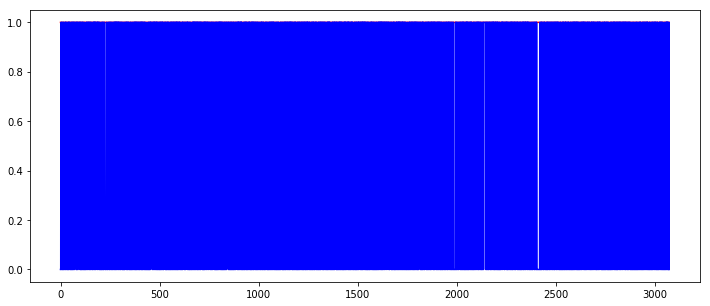

Epoch : 1/3, running_loss : 0.59375 
Epoch : 1/3, running_loss : 0.65625 
Epoch : 1/3, running_loss : 0.375 
Epoch : 1/3, running_loss : 0.6875 
Epoch : 1/3, running_loss : 0.4375 
Epoch : 1/3, running_loss : 0.375 
Epoch : 1/3, running_loss : 0.59375 
Epoch : 1/3, running_loss : 0.625 
Epoch : 1/3, running_loss : 0.5 
Epoch : 1/3, running_loss : 0.5 
Epoch : 1/3, running_loss : 0.53125 
Epoch : 1/3, running_loss : 0.59375 
Epoch : 1/3, running_loss : 0.53125 
Epoch : 1/3, running_loss : 0.71875 
Epoch : 1/3, running_loss : 0.34375 
Epoch : 1/3, running_loss : 0.59375 
Epoch : 1/3, running_loss : 0.5 
Epoch : 1/3, running_loss : 0.59375 
Epoch : 1/3, running_loss : 0.53125 
Epoch : 1/3, running_loss : 0.4375 
Epoch : 1/3, running_loss : 0.59375 
Epoch : 1/3, running_loss : 0.46875 
Epoch : 1/3, running_loss : 0.4375 
Epoch : 1/3, running_loss : 0.40625 
Epoch : 1/3, running_loss : 0.5625 
Epoch : 1/3, running_loss : 0.5625 
Epoch : 1/3, running_loss : 0.53125 
Epoch : 1/3, running_loss

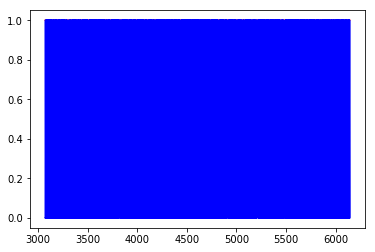

Epoch : 2/3, running_loss : 0.59375 
Epoch : 2/3, running_loss : 0.65625 
Epoch : 2/3, running_loss : 0.375 
Epoch : 2/3, running_loss : 0.6875 
Epoch : 2/3, running_loss : 0.4375 
Epoch : 2/3, running_loss : 0.375 
Epoch : 2/3, running_loss : 0.59375 
Epoch : 2/3, running_loss : 0.625 
Epoch : 2/3, running_loss : 0.5 
Epoch : 2/3, running_loss : 0.5 
Epoch : 2/3, running_loss : 0.53125 
Epoch : 2/3, running_loss : 0.59375 
Epoch : 2/3, running_loss : 0.53125 
Epoch : 2/3, running_loss : 0.71875 
Epoch : 2/3, running_loss : 0.34375 
Epoch : 2/3, running_loss : 0.59375 
Epoch : 2/3, running_loss : 0.5 
Epoch : 2/3, running_loss : 0.59375 
Epoch : 2/3, running_loss : 0.53125 
Epoch : 2/3, running_loss : 0.4375 
Epoch : 2/3, running_loss : 0.59375 
Epoch : 2/3, running_loss : 0.46875 
Epoch : 2/3, running_loss : 0.4375 
Epoch : 2/3, running_loss : 0.40625 
Epoch : 2/3, running_loss : 0.5625 
Epoch : 2/3, running_loss : 0.5625 
Epoch : 2/3, running_loss : 0.53125 
Epoch : 2/3, running_loss

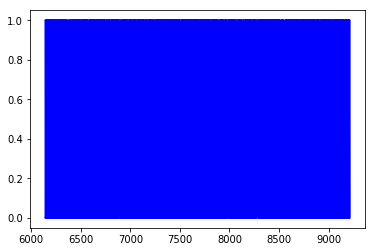

In [415]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

trained = train(model, 21,100,1, trainloader)

In [417]:
trained

Model(
  (rnn): RNN(21, 32, num_layers=2, batch_first=True, dropout=0.05)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (softmax): Sigmoid()
)

In [416]:
accuracy_test(trained)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.